We import all the library that we will need for this project

In [38]:
import pandas as pd
import numpy as np
import requests

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 
from sklearn.cluster import KMeans #Clustering fonction
#plotting modules from matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
!conda install -c conda-forge folium=0.5.0 --yes 

import folium # map rendering library

import json # library to handle JSON files
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



# Capstone Project 

## Introduction/Business Problem

We are a consulting society specialized in datascience applied to business. Our client ask us where he should install his society. He chose Paris but didn't decide now the neighborhood. We need to make a study to find the neighborhood that suits the best. This project is very important for my client because he would have more possibilities of succeed if the neighborhood has been chosen wisely. In the other hand, a bad choice would make a bad start and would be really detrimental for the company. 
We have to compare different neighborhood, and find the ones that fits the best with the client's expectation. The client's business will be a shop specialized in Japanese food.

## Data

We will massively use Foursquare in this analysis. We make the assumption that people interessed in Japanese food in Paris are also interessed in other Asian food. We will then focus on data relative to Asian food in Paris. It will be shop, restaurant.. We will also cluster the different neighborhood in Paris and validate our analysis based on the clustering with data visualisation. That means that we need neighborhood venues. Then we will choose the neighborhood that fits the best with all information that we will have gathered. Finally, we will get all Paris neighborhood from a csv file. This is open data 

https://opendata.paris.fr/explore/dataset/quartier_paris/export/?dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6InF1YXJ0aWVyX3BhcmlzIiwib3B0aW9ucyI6e319LCJjaGFydHMiOlt7ImFsaWduTW9udGgiOnRydWUsInR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQVZHIiwieUF4aXMiOiJuX3NxX3F1Iiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoiIzAwMzM2NiJ9XSwieEF4aXMiOiJsX3F1IiwibWF4cG9pbnRzIjo1MCwic29ydCI6IiJ9XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D

We also get all Paris' Borough in order to make a visualisation of the asian restaurant popularity in Paris thanks to a geojson data file

In [2]:
# @hidden_cell
CLIENT_ID = 'ODSQTRMSAFMCAM53ZP5ZJ4Y0DJECUY1DJQCNL3TEQFX03FO5' # your Foursquare ID
CLIENT_SECRET = 'BUIC2UJZOZ3OKMHHQYSIX3MKUIX0UZKSC2GEYVCQI5YAKPQ4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

### Neighborhood data

Let's get all Paris neighborhood from the csv file

In [315]:
Paris_neighborhood =  pd.read_csv("quartier_paris.csv", delimiter=';')
Paris_neighborhood.head(4)

,N_SQ_QU,C_QU,C_QUINSEE,L_QU,C_AR,N_SQ_AR,PERIMETRE,SURFACE,Geometry X Y,Geometry
0,750000036,36,7510904,Rochechouart,9,750000009,2862.450525,5.004354e+05,"48.8798119198,2.344861291","{""type"": ""Polygon"", ""coordinates"": [[[2.349708..."
1,750000047,47,7511203,Bercy,12,750000012,6155.005036,1.902932e+06,"48.8352090499,2.38621008421","{""type"": ""Polygon"", ""coordinates"": [[[2.391141..."
2,750000002,2,7510102,Halles,1,750000001,2606.417128,4.124585e+05,"48.8622891081,2.34489885831","{""type"": ""Polygon"", ""coordinates"": [[[2.349365..."
3,750000026,26,7510702,Invalides,7,750000007,4434.656489,1.073734e+06,"48.8585149661,2.31644474034","{""type"": ""Polygon"", ""coordinates"": [[[2.319011..."


We drop all columns that we will not use in our analysis

In [316]:
Paris_neighborhood = Paris_neighborhood.drop(["N_SQ_QU","C_QU","C_QUINSEE","PERIMETRE","SURFACE","N_SQ_AR","Geometry"],axis=1)
Paris_neighborhood = Paris_neighborhood.rename(columns={"C_AR":"Borough","L_QU":"Neighborhood"})
Paris_neighborhood.head(4)

,Neighborhood,Borough,Geometry X Y
0,Rochechouart,9,"48.8798119198,2.344861291"
1,Bercy,12,"48.8352090499,2.38621008421"
2,Halles,1,"48.8622891081,2.34489885831"
3,Invalides,7,"48.8585149661,2.31644474034"


We split Geometry X Y into two columns : Longitude and Latitude, that we will use later in our analysis then we drop Geometry X Y that we will not need anymore

In [317]:
print(str(Paris_neighborhood["Geometry X Y"][0]).split(','))
Paris_neighborhood["Latitude"] = float(str(Paris_neighborhood["Geometry X Y"][0]).split(',')[0].replace(" ",""))
Paris_neighborhood["Longitude"] = float(str(Paris_neighborhood["Geometry X Y"][0]).split(',')[1].replace(" ",""))
for i in range(len(Paris_neighborhood.index)):
    Paris_neighborhood["Latitude"][i] = float(str(Paris_neighborhood["Geometry X Y"][i]).split(',')[0].replace(" ",""))
    Paris_neighborhood["Longitude"][i] = float(str(Paris_neighborhood["Geometry X Y"][i]).split(',')[1])
Paris_neighborhood = Paris_neighborhood.drop(["Geometry X Y"],axis=1)
Paris_neighborhood.head(4)

['48.8798119198', '2.344861291']


<ipython-input-317-f147292a8960>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Paris_neighborhood["Latitude"][i] = float(str(Paris_neighborhood["Geometry X Y"][i]).split(',')[0].replace(" ",""))
<ipython-input-317-f147292a8960>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Paris_neighborhood["Longitude"][i] = float(str(Paris_neighborhood["Geometry X Y"][i]).split(',')[1])


,Neighborhood,Borough,Latitude,Longitude
0,Rochechouart,9,48.879812,2.344861
1,Bercy,12,48.835209,2.386210
2,Halles,1,48.862289,2.344899
3,Invalides,7,48.858515,2.316445


### Forsquare Data

We need to define two functions that will help us to gather all venues into a radius and some coordinates. Then another function that mitigate the results at one category

In [80]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [78]:
def getNearCategorybyVenues(names, latitudes, longitudes, category, radius=500  ):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            category,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We get all the venues in Paris on a radius of 500 meter around each Neighborhood center

In [81]:
Paris_venues = getNearbyVenues(names=Paris_neighborhood['Neighborhood'],
                                   latitudes=Paris_neighborhood['Latitude'],
                                   longitudes=Paris_neighborhood['Longitude']
                                  )

Rochechouart
Bercy
Halles
Invalides
Faubourg-Montmartre
Gaillon
Amérique
Saint-Gervais
Saint-Thomas-d'Aquin
Porte-Saint-Denis
Saint-Germain-l'Auxerrois
Villette
Arsenal
Jardin-des-Plantes
Porte-Saint-Martin
Roquette
Picpus
Plaisance
Saint-Merri
Notre-Dame
Gros-Caillou
Val-de-Grâce
Necker
Père-Lachaise
La Chapelle
Sainte-Avoie
Hôpital-Saint-Louis
Belleville
Ternes
Notre-Dame-des-Champs
Petit-Montrouge
Pont-de-Flandre
Muette
Chaillot
Epinettes
Ecole-Militaire
Grenelle
Auteuil
Quinze-Vingts
Sorbonne
Saint-Georges
Chaussée-d'Antin
Palais-Royal
Batignolles
Mail
Bonne-Nouvelle
Gare
Clignancourt
Goutte-d'Or
Arts-et-Métiers
Archives
Faubourg-du-Roule
Vivienne
Enfants-Rouges
Saint-Germain-des-Prés
Saint-Vincent-de-Paul
Saint-Ambroise
Bel-Air
Montparnasse
Plaine de Monceaux
Europe
Sainte-Marguerite
Parc-de-Montsouris
Saint-Lambert
Folie-Méricourt
Salpêtrière
Place-Vendôme
Combat
Charonne
Javel
Monnaie
Odéon
Champs-Elysées
Maison-Blanche
Croulebarbe
Saint-Victor
Madeleine
Saint-Fargeau
Porte-Daup

We also get all venue of each asiatic restaurant in Paris, then each bubble tea shop, with the same protocol

In [236]:
Asian_Paris_venues = getNearCategorybyVenues(names=Paris_neighborhood['Neighborhood'],
                                   latitudes=Paris_neighborhood['Latitude'],
                                   longitudes=Paris_neighborhood['Longitude'],
                               category="4bf58dd8d48988d142941735")

Rochechouart
Bercy
Halles
Invalides
Faubourg-Montmartre
Gaillon
Amérique
Saint-Gervais
Saint-Thomas-d'Aquin
Porte-Saint-Denis
Saint-Germain-l'Auxerrois
Villette
Arsenal
Jardin-des-Plantes
Porte-Saint-Martin
Roquette
Picpus
Plaisance
Saint-Merri
Notre-Dame
Gros-Caillou
Val-de-Grâce
Necker
Père-Lachaise
La Chapelle
Sainte-Avoie
Hôpital-Saint-Louis
Belleville
Ternes
Notre-Dame-des-Champs
Petit-Montrouge
Pont-de-Flandre
Muette
Chaillot
Epinettes
Ecole-Militaire
Grenelle
Auteuil
Quinze-Vingts
Sorbonne
Saint-Georges
Chaussée-d'Antin
Palais-Royal
Batignolles
Mail
Bonne-Nouvelle
Gare
Clignancourt
Goutte-d'Or
Arts-et-Métiers
Archives
Faubourg-du-Roule
Vivienne
Enfants-Rouges
Saint-Germain-des-Prés
Saint-Vincent-de-Paul
Saint-Ambroise
Bel-Air
Montparnasse
Plaine de Monceaux
Europe
Sainte-Marguerite
Parc-de-Montsouris
Saint-Lambert
Folie-Méricourt
Salpêtrière
Place-Vendôme
Combat
Charonne
Javel
Monnaie
Odéon
Champs-Elysées
Maison-Blanche
Croulebarbe
Saint-Victor
Madeleine
Saint-Fargeau
Porte-Daup

In [237]:
Bubble_Tea_Paris_venues = getNearCategorybyVenues(names=Paris_neighborhood['Neighborhood'],
                                   latitudes=Paris_neighborhood['Latitude'],
                                   longitudes=Paris_neighborhood['Longitude'],
                               category="52e81612bcbc57f1066b7a0c")

Rochechouart
Bercy
Halles
Invalides
Faubourg-Montmartre
Gaillon
Amérique
Saint-Gervais
Saint-Thomas-d'Aquin
Porte-Saint-Denis
Saint-Germain-l'Auxerrois
Villette
Arsenal
Jardin-des-Plantes
Porte-Saint-Martin
Roquette
Picpus
Plaisance
Saint-Merri
Notre-Dame
Gros-Caillou
Val-de-Grâce
Necker
Père-Lachaise
La Chapelle
Sainte-Avoie
Hôpital-Saint-Louis
Belleville
Ternes
Notre-Dame-des-Champs
Petit-Montrouge
Pont-de-Flandre
Muette
Chaillot
Epinettes
Ecole-Militaire
Grenelle
Auteuil
Quinze-Vingts
Sorbonne
Saint-Georges
Chaussée-d'Antin
Palais-Royal
Batignolles
Mail
Bonne-Nouvelle
Gare
Clignancourt
Goutte-d'Or
Arts-et-Métiers
Archives
Faubourg-du-Roule
Vivienne
Enfants-Rouges
Saint-Germain-des-Prés
Saint-Vincent-de-Paul
Saint-Ambroise
Bel-Air
Montparnasse
Plaine de Monceaux
Europe
Sainte-Marguerite
Parc-de-Montsouris
Saint-Lambert
Folie-Méricourt
Salpêtrière
Place-Vendôme
Combat
Charonne
Javel
Monnaie
Odéon
Champs-Elysées
Maison-Blanche
Croulebarbe
Saint-Victor
Madeleine
Saint-Fargeau
Porte-Daup

We will use both of them later. First at all, let's visualize all neighborhood in Paris

In [47]:
address = 'Paris'

geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


In [111]:
paris_center = [latitude,longitude]
map_paris = folium.Map(location=paris_center, zoom_start=12)
for lat, lng, borough, neighborhood in zip(Paris_neighborhood['Latitude'], Paris_neighborhood['Longitude'], Paris_neighborhood['Borough'], Paris_neighborhood['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

We have right now all the data that we need to do our analysis

## Methodology

In a first time we got all the infos we need thanks to open data and foursquare. Then we make a clustering by merging them with foursquare's venue data. We identify the cluster that countain the most the asian restaurant, then we confront this with a data visualisation of asian venue.
We will have good insight about the borough where we should implement the japanese shop.

## Analysis

We need to make a one hot encoding to transform categorical value into numeric value

In [82]:
# one hot encoding
paris_onehot = pd.get_dummies(Paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = Paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Rochechouart,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rochechouart,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rochechouart,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,Rochechouart,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Rochechouart,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
paris_onehot.shape

(5111, 307)

Now, let's have the proportion of each category depending on the neighborhood

In [85]:
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
paris_grouped.head(5)

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Amérique,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.00,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,Archives,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.05,...,0.000000,0.0,0.0,0.000000,0.010000,0.000000,0.000000,0.0,0.0,0.0
2,Arsenal,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.00,...,0.028571,0.0,0.0,0.000000,0.014286,0.000000,0.000000,0.0,0.0,0.0
3,Arts-et-Métiers,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.01,0.02,...,0.020000,0.0,0.0,0.030000,0.050000,0.020000,0.000000,0.0,0.0,0.0
4,Auteuil,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.00,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Sorbonne,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.00,...,0.000000,0.0,0.0,0.010000,0.020000,0.000000,0.000000,0.0,0.0,0.0
76,Ternes,0.0,0.0,0.0,0.0,0.014925,0.000000,0.0,0.00,0.00,...,0.000000,0.0,0.0,0.014925,0.014925,0.000000,0.000000,0.0,0.0,0.0
77,Val-de-Grâce,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.00,...,0.000000,0.0,0.0,0.000000,0.023256,0.000000,0.000000,0.0,0.0,0.0
78,Villette,0.0,0.0,0.0,0.0,0.016667,0.000000,0.0,0.00,0.00,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


We get the most common venues to better know how the cluster will be made

In [159]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [310]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amérique,Bus Stop,French Restaurant,Plaza,Supermarket,Bank,Pool,Park,Bed & Breakfast,Café,Bistro
1,Archives,French Restaurant,Hotel,Art Gallery,Coffee Shop,Clothing Store,Bar,Bistro,Bookstore,Cocktail Bar,Japanese Restaurant
2,Arsenal,French Restaurant,Hotel,Plaza,Park,Gastropub,Boat or Ferry,Italian Restaurant,Pedestrian Plaza,Seafood Restaurant,Thai Restaurant
3,Arts-et-Métiers,French Restaurant,Hotel,Cocktail Bar,Italian Restaurant,Wine Bar,Chinese Restaurant,Vietnamese Restaurant,Bar,Restaurant,Coffee Shop
4,Auteuil,Tennis Court,Stadium,Garden,Sporting Goods Shop,Outdoors & Recreation,Racecourse,French Restaurant,Plaza,Museum,Botanical Garden


We plot a graph of the K value vs inertia to get the optimal K. 4 should be fine for this problem, but the slope become higher between 5 and 7 then we choose 7

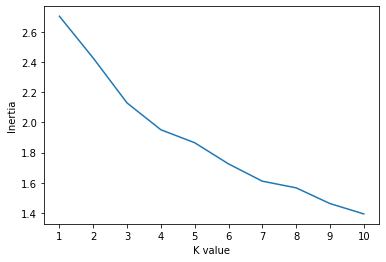

In [311]:
# set the max number of clusters
kclusters_max = 10
variances = []
kmeans = []
K = [i for i in range(1,kclusters_max+1)]
paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)
for i in range(1,kclusters_max+1):
    variance=0
    model_KM = KMeans(n_clusters=i, random_state=1).fit(paris_grouped_clustering)
    kmeans.append(model_KM)
    variances.append(model_KM.inertia_)

plt.plot(K,variances)
plt.ylabel("Inertia")
plt.xlabel("K value")
plt.xticks([i for i in range(1,kclusters_max+1)])
plt.show()

We try different random initialisation and we keep the minimal variance after the fit, to get the best model 

In [312]:
# set number of clusters
kclusters = 7
states = [i for i in range(100)]
variances_random = []
Kmeans_random = []
for i in range(len(states)):
    variance=0
    model_KM = KMeans(n_clusters=kclusters, random_state=i).fit(paris_grouped_clustering)
    Kmeans_random.append(model_KM)
    variances_random.append(model_KM.inertia_)
print(min(variances_random))
index_min = variances_random.index(min(variances_random))


1.5931468024464341


We merge out neighborhood data with venue data that we gathered. We keep only the 10 most accurate venues for each neighborhood

In [313]:
# add clustering labels
#neighborhoods_venues_sorted.drop(["Cluster Labels"],axis=1)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', Kmeans_random[index_min].labels_)
paris_merged = Paris_neighborhood

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

paris_merged.head() # check the last columns!

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rochechouart,9,48.879812,2.344861,0,French Restaurant,Hotel,Bakery,Vegetarian / Vegan Restaurant,Pizza Place,Wine Bar,Restaurant,Park,Coffee Shop,Thai Restaurant
1,Bercy,12,48.835209,2.386210,1,Hotel,Bakery,Italian Restaurant,Supermarket,Pastry Shop,Museum,Japanese Restaurant,French Restaurant,Breakfast Spot,Burger Joint
2,Halles,1,48.862289,2.344899,0,French Restaurant,Coffee Shop,Hotel,Chinese Restaurant,Ice Cream Shop,Restaurant,Bakery,Pedestrian Plaza,Art Gallery,Sandwich Place
3,Invalides,7,48.858515,2.316445,0,French Restaurant,Hotel,Plaza,Café,History Museum,Italian Restaurant,Park,Art Museum,Bistro,Vegetarian / Vegan Restaurant
4,Faubourg-Montmartre,9,48.873935,2.343253,0,French Restaurant,Hotel,Italian Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Japanese Restaurant,Chinese Restaurant,Gym / Fitness Center,Thai Restaurant,Gourmet Shop


We create the map that showcase our clustering

In [211]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'],paris_merged['Neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

We have a look on each cluster's content, then we keep the cluster that is the more relevant for our business problem

In [212]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,9,48.879812,2.344861,0,French Restaurant,Hotel,Bakery,Vegetarian / Vegan Restaurant,Pizza Place,Wine Bar,Restaurant,Park,Coffee Shop,Thai Restaurant
2,1,48.862289,2.344899,0,French Restaurant,Coffee Shop,Hotel,Chinese Restaurant,Ice Cream Shop,Restaurant,Bakery,Pedestrian Plaza,Art Gallery,Sandwich Place
3,7,48.858515,2.316445,0,French Restaurant,Hotel,Plaza,Café,History Museum,Italian Restaurant,Park,Art Museum,Bistro,Vegetarian / Vegan Restaurant
4,9,48.873935,2.343253,0,French Restaurant,Hotel,Italian Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Japanese Restaurant,Chinese Restaurant,Gym / Fitness Center,Thai Restaurant,Gourmet Shop
8,7,48.855263,2.325588,0,French Restaurant,Hotel,Italian Restaurant,Bakery,Café,Coffee Shop,Art Gallery,Tailor Shop,Garden,Brasserie
12,4,48.851585,2.364768,0,French Restaurant,Hotel,Plaza,Park,Gastropub,Boat or Ferry,Italian Restaurant,Pedestrian Plaza,Seafood Restaurant,Thai Restaurant
18,4,48.858521,2.351667,0,French Restaurant,Hotel,Ice Cream Shop,Art Gallery,Plaza,Bakery,Historic Site,Coffee Shop,Portuguese Restaurant,Clothing Store
19,4,48.852896,2.352775,0,French Restaurant,Bakery,Japanese Restaurant,Ice Cream Shop,Wine Bar,Coffee Shop,Plaza,Italian Restaurant,Cupcake Shop,Flower Shop
20,7,48.858300,2.301542,0,French Restaurant,Italian Restaurant,Hotel,Café,Bistro,Coffee Shop,Bakery,Ice Cream Shop,Burger Joint,Vietnamese Restaurant
28,17,48.881178,2.289964,0,French Restaurant,Italian Restaurant,Hotel,Seafood Restaurant,Hotel Bar,Bakery,Pizza Place,Japanese Restaurant,Moroccan Restaurant,Bistro


In [213]:
asian_cluster = paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]
asian_cluster

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,12,48.835209,2.386210,1,Hotel,Bakery,Italian Restaurant,Supermarket,Pastry Shop,Museum,Japanese Restaurant,French Restaurant,Breakfast Spot,Burger Joint
5,2,48.869307,2.333432,1,Japanese Restaurant,Hotel,French Restaurant,Chocolate Shop,Coffee Shop,Wine Bar,Pastry Shop,Korean Restaurant,Asian Restaurant,Plaza
7,4,48.855719,2.358162,1,French Restaurant,Clothing Store,Hotel,Pastry Shop,Gourmet Shop,Cultural Center,Pedestrian Plaza,Furniture / Home Store,Ice Cream Shop,Wine Bar
9,10,48.873618,2.352283,1,Hotel,French Restaurant,Bistro,Vegetarian / Vegan Restaurant,Bakery,Japanese Restaurant,Bar,Restaurant,Fast Food Restaurant,Indian Restaurant
11,19,48.887661,2.374468,1,Hotel,Bar,Café,French Restaurant,Asian Restaurant,Italian Restaurant,Multiplex,Food Truck,Bistro,Fast Food Restaurant
13,5,48.841940,2.356894,1,French Restaurant,Science Museum,Hotel,Garden,Bakery,Italian Restaurant,Greek Restaurant,Moroccan Restaurant,Museum,Plaza
14,10,48.871245,2.361504,1,Coffee Shop,French Restaurant,Asian Restaurant,Theater,Cambodian Restaurant,Breakfast Spot,Cocktail Bar,Hotel,Bakery,Mexican Restaurant
15,11,48.857064,2.380364,1,French Restaurant,Bar,Bistro,Cocktail Bar,Café,Italian Restaurant,Pastry Shop,Japanese Restaurant,Supermarket,Bakery
21,5,48.841684,2.343861,1,French Restaurant,Bar,Hotel,Creperie,Asian Restaurant,Chinese Restaurant,Café,Bistro,Bakery,Farmers Market
23,20,48.863719,2.395273,1,Bakery,Bistro,Bar,Japanese Restaurant,Plaza,French Restaurant,Wine Bar,Italian Restaurant,Park,Latin American Restaurant


In [214]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,12,48.830359,2.428827,2,Locksmith,Pastry Shop,Hotel,Farmers Market,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Exhibit,Falafel Restaurant


In [215]:
paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,16,48.850622,2.252277,3,Tennis Court,Stadium,Garden,Sporting Goods Shop,Outdoors & Recreation,Racecourse,French Restaurant,Plaza,Museum,Botanical Garden


In [216]:
paris_merged.loc[paris_merged['Cluster Labels'] == 4, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,19,48.881638,2.395440,4,Bus Stop,French Restaurant,Plaza,Supermarket,Bank,Pool,Park,Bed & Breakfast,Café,Bistro
57,12,48.837996,2.433178,4,French Restaurant,Botanical Garden,Plaza,Playground,Café,Sports Club,Recreation Center,Hotel Bar,Hotel,Eastern European Restaurant
73,13,48.823128,2.352433,4,French Restaurant,Plaza,Bistro,Café,Supermarket,Pizza Place,Bakery,Tram Station,Garden,Southwestern French Restaurant
77,20,48.871035,2.406172,4,Plaza,Supermarket,French Restaurant,Café,Bakery,Bistro,Diner,Pizza Place,Gas Station,Arts & Entertainment
78,16,48.871766,2.271918,4,Grocery Store,Pizza Place,Supermarket,Café,Tennis Court,Park,Gym / Fitness Center,Gym Pool,Train Station,Museum


In [217]:
paris_merged.loc[paris_merged['Cluster Labels'] == 5, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,1,48.860650,2.334910,5,French Restaurant,Hotel,Plaza,Art Museum,Historic Site,Café,Italian Restaurant,Japanese Restaurant,Cosmetics Shop,Coffee Shop
17,14,48.830317,2.315305,5,Hotel,French Restaurant,Bistro,Grocery Store,Japanese Restaurant,Bar,Bakery,Thai Restaurant,Park,Sushi Restaurant
22,15,48.842711,2.310777,5,French Restaurant,Hotel,Dessert Shop,Café,Gym / Fitness Center,Pizza Place,Plaza,Grocery Store,Gourmet Shop,Bistro
30,14,48.826653,2.326437,5,Hotel,French Restaurant,Italian Restaurant,Supermarket,Sandwich Place,Bakery,Food & Drink Shop,Plaza,Sushi Restaurant,Bistro
33,16,48.868434,2.291679,5,Hotel,French Restaurant,Italian Restaurant,Café,Bakery,Art Museum,Japanese Restaurant,Chinese Restaurant,Plaza,Roof Deck
35,7,48.850359,2.311031,5,Hotel,French Restaurant,Plaza,Diner,Bistro,Pastry Shop,Garden,Café,Farmers Market,Dessert Shop
36,15,48.850172,2.291853,5,Hotel,French Restaurant,Japanese Restaurant,Pizza Place,Italian Restaurant,Bakery,Bistro,Coffee Shop,Cheese Shop,Tapas Restaurant
40,9,48.879934,2.332850,5,Hotel,French Restaurant,Italian Restaurant,Cocktail Bar,Bistro,Café,Vietnamese Restaurant,Lounge,Bakery,Comedy Club
41,9,48.873547,2.332269,5,Hotel,French Restaurant,Salad Place,Clothing Store,Coffee Shop,Bistro,Vietnamese Restaurant,Department Store,Gym / Fitness Center,Theater
51,8,48.874136,2.304119,5,French Restaurant,Hotel,Clothing Store,Italian Restaurant,Jewelry Store,Café,Department Store,Cosmetics Shop,Men's Store,Hotel Bar


In [218]:
paris_merged.loc[paris_merged['Cluster Labels'] == 6, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,16,48.863275,2.259936,6,French Restaurant,Pool,Snack Place,Diner,Lake,Boat or Ferry,Gym / Fitness Center,Flea Market,Fish Market,Flower Shop


We create a map that contains only the neighborhood of the second cluster

In [235]:
# create map
map_clusters_asian = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to the map
markers_colors = []
for lat, lon in zip(asian_cluster['Latitude'], asian_cluster['Longitude']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.9).add_to(map_clusters_asian)
       
map_clusters_asian

The neiborhood in first, second and third borough seems to be the more promicing for our business. Let's verify this with the two other dataset that we gathered from foursquared : the asian restaurant dataset and the bubble tea dataset

In [255]:
asian_count = Asian_Paris_venues.groupby("Neighborhood")["Venue"].count().reset_index()
asian_count = asian_count.rename(columns={"Venue":"Asian_Venue"})
asian_count.head(5)

,Neighborhood,Asian_Venue
0,Amérique,5
1,Archives,29
2,Arsenal,16
3,Arts-et-Métiers,55
4,Batignolles,26
...,...,...
70,Sorbonne,56
71,Ternes,21
72,Val-de-Grâce,24
73,Villette,11


In [256]:
bubble_count = Bubble_Tea_Paris_venues.groupby("Neighborhood")["Venue"].count().reset_index()
bubble_count = bubble_count.rename(columns={"Venue":"Bubble_Venue"})
bubble_count.head(5)

,Neighborhood,Bubble_Venue
0,Arts-et-Métiers,3
1,Bonne-Nouvelle,2
2,Champs-Elysées,3
3,Chaussée-d'Antin,5
4,Croulebarbe,2
5,Enfants-Rouges,3
6,Faubourg-Montmartre,4
7,Faubourg-du-Roule,1
8,Folie-Méricourt,3
9,Gaillon,9


We counted all venue depending on neighborhood, then we merge both on them with the Paris' neighborhood dataset

In [318]:
Asian_merged = Paris_neighborhood.merge(asian_count,how='left',on="Neighborhood")
Asian_merged = Asian_merged.merge(bubble_count,how='left',on="Neighborhood")
Asian_merged = Asian_merged.fillna(0)
Asian_merged["Total_Venue"] = Asian_merged["Asian_Venue"]+Asian_merged["Bubble_Venue"]
Asian_merged=Asian_merged.drop(["Bubble_Venue","Asian_Venue"],axis=1)
Asian_merged.head(4)

,Neighborhood,Borough,Latitude,Longitude,Total_Venue
0,Rochechouart,9,48.879812,2.344861,39.0
1,Bercy,12,48.835209,2.386210,14.0
2,Halles,1,48.862289,2.344899,71.0
3,Invalides,7,48.858515,2.316445,4.0


We have now a column that countains the contribution of each dataset. We sum them for each borough

In [319]:
total_count = Asian_merged.groupby("Borough").sum().reset_index()
total_count = total_count[["Borough","Total_Venue"]]
total_count.head(4)

,Borough,Total_Venue
0,1,261.0
1,2,368.0
2,3,211.0
3,4,131.0


We create then a map that shows the most popular borough

In [298]:
map_asian_venue = folium.Map(location=[latitude, longitude], zoom_start=12)

In [294]:
arrondissement_geo = r'arrondissements.geojson' # geojson file

In [299]:
# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
map_asian_venue.choropleth(
    geo_data=arrondissement_geo,
    data=total_count,
    columns=["Borough","Total_Venue"],
    key_on='feature.properties.c_ar',
    fill_color='YlOrRd', 
    fill_opacity='0.7', 
    line_opacity='0.2',
    legend_name='Asiatic restaurant popularity'
)

# display map
map_asian_venue

## Result and discussion

First at all, we can see that the results are conclusive. The clusters that we made were relevant for our business problem, and there is a real contribution of the First, second and third borough, that indicates that we should make a shop in one of them. So the results are mostly positive, but it hides a big problem with data.
The data that foursquare gather are data from tourist. Then, we will have only the touristic venue, and nothing about people living in Paris. For example, the thirteenth borough has a big asian venue contribution, but this contribution can't be see with this data. Then, we lose a big part of the information, and that could lead to a failed business, because there could be have more interesting borough or neighborhoods for the shop.
We need then to make further exploration, and get a dataset that would allow us to have a view on local behavior about restauration. 
With this exploration, we could conclude that we must invest on first borough (the most interesting), but we also saw that this exploration is insufficient because of the lack of local behavior information. 
The second problem is that the first, second and third borough have especially really expensive rent, that could be problematic if we pick one of them

## Conclusion

The purpose of this analysis was to find the best neighborhood where we should implement the japanese shop. This analysis is efficient if we only consider tourist information, but local behavior could be really interesting too. Then we can't really conclude properly, all we need is futher investigation to gather more data source and analyse them.